In [1]:
#https://github.com/olgaliak/detection-amlworkbench/tree/master/assets
#!wget https://olgalicodestory.blob.core.windows.net/kittiwakedata/kittiwake_labled.zip
#!unzip kittiwake_labled.zip
#!rm kittiwake_labled.zip

In [2]:
import os
import glob
import json
import numpy as np
import torchvision
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
# Bit messy to use chainercv to visualise ...
from chainercv.visualizations import vis_bbox  # todo

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
PATH = "kittiwake_labled/"

In [4]:
with open(os.path.join(PATH, "train.json"), 'r') as annofile:
    labels = json.load(annofile) 

In [5]:
class BirdsData(Dataset):
    
    def __init__(self, img_dir, lbl_file, transform=None):
        self.img_locs = glob.glob(os.path.join(img_dir, "*.JPG"))
        with open(lbl_file, 'r') as annofile:
            self.labels = json.load(annofile) 
        self.transform = transform
        print("Loaded {} images".format(len(self.img_locs)))
        
    def __getitem__(self, idx):
        im_file = self.img_locs[idx]

        # BBoxes fixed to w=1269,h=952
        # Resized before transform to match label
        im_rgb = Image.open(im_file).resize((1269, 952))
        
        # Bounding boxes: (y_{min}, x_{min}, y_{max}, x_{max}
        img_no = str(int(os.path.basename(
            os.path.splitext(im_file)[0])))
        labels = self.labels['frames'][img_no]
        # 'ymin', 'xmin', 'ymax', 'xmax'
        bboxes = np.array([
            (l['y1'], l['x1'], l['y2'], l['x2']) for l in labels])
        # For batch
        #bboxes = np.expand_dims(bboxes, axis=0)
        
        # Class labels (start at 0)
        #cls_label = np.zeros(bboxes.shape[1])
        cls_label = np.zeros(len(bboxes))
        # For batch
        #cls_label = np.expand_dims(cls_label, axis=0)
        
        if self.transform is not None:
            im_rgb = self.transform(im_rgb)
        # return img.copy(), bbox.copy(), label.copy(), scale
        return im_rgb, torch.FloatTensor(bboxes), torch.FloatTensor(cls_label), 1
        
    def __len__(self):
        return len(self.img_locs)

In [6]:
# Init dataset
train_dataset = BirdsData(
    img_dir = os.path.join(PATH, "train"),
    lbl_file = os.path.join(PATH, "train.json"))

Loaded 160 images


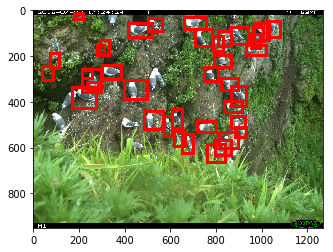

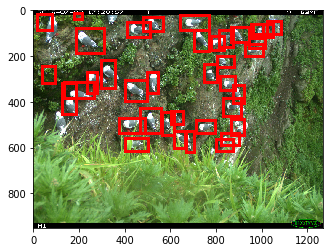

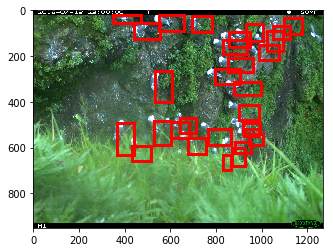

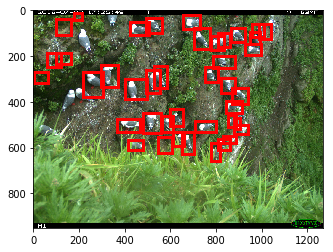

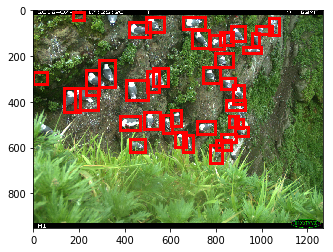

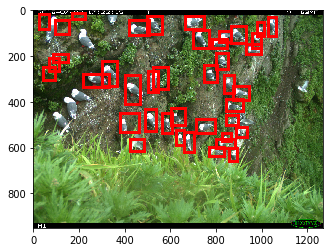

In [7]:
# Visualise rndm images
for i in [5, 16, 24, 25, 131, 141]:
    im, boxes, cls_lab, scale = train_dataset[i]
    im_array = np.moveaxis(np.array(im),-1,0)
    vis_bbox(im_array, boxes)

In [8]:
# Train Default Model

In [9]:
# Model specific imports
from model.faster_rcnn import FasterRCNN
from model.region_proposal_network import RegionProposalNetwork
from model.faster_rcnn_vgg16 import VGG16RoIHead, decom_vgg16
# Training imports
import torchvision.transforms as transforms
from tqdm import tqdm
from trainer import FasterRCNNTrainer
from utils import array_tool as at

/home/iliauk/simple-faster-rcnn-pytorch/model/utils/nms/non_maximum_suppression.py:12: UserWarning: 
    the python code for non_maximum_suppression is about 2x slow
    It is strongly recommended to build cython code: 
    `cd model/utils/nms/; python3 build.py build_ext --inplace
  `cd model/utils/nms/; python3 build.py build_ext --inplace''')


In [10]:
# Init dataset
train_dataset = BirdsData(
    img_dir = os.path.join(PATH, "train"),
    lbl_file = os.path.join(PATH, "train.json"), 
    transform=transforms.ToTensor())

# Loader
dataloader = DataLoader(train_dataset, 
                        batch_size=1,
                        shuffle=True)

Loaded 160 images


In [11]:
# Model: Default using VGG16
class FasterRCNNVGG16(FasterRCNN):

    feat_stride = 16  # downsample 16x for output of conv5 in vgg16

    def __init__(self,
                 n_fg_class=20,
                 ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32]):
                 
        # Note that vgg16 is used for backbone and classifier 
        extractor, classifier = decom_vgg16()
        #print("Backbone: ", extractor)
        
        rpn = RegionProposalNetwork(
            512, 512,
            ratios=ratios,
            anchor_scales=anchor_scales,
            feat_stride=self.feat_stride)
        print("Region Proposal Network: ", rpn)

        head = VGG16RoIHead(
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / self.feat_stride),
            classifier=classifier)
        print("Head: ", head)
        
        super(FasterRCNNVGG16, self).__init__(
            extractor,
            rpn,
            head)

In [12]:
# Initiate model
faster_rcnn = FasterRCNNVGG16()

Region Proposal Network:  RegionProposalNetwork(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (score): Conv2d(512, 18, kernel_size=(1, 1), stride=(1, 1))
  (loc): Conv2d(512, 36, kernel_size=(1, 1), stride=(1, 1))
)
Head:  VGG16RoIHead(
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU(inplace)
  )
  (cls_loc): Linear(in_features=4096, out_features=84, bias=True)
  (score): Linear(in_features=4096, out_features=21, bias=True)
  (roi): RoIPooling2D()
)


In [13]:
# Initiate trainer with model
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

In [ ]:
# Train one-epoch
for ii, (img, bbox_, label_, scale) in tqdm(enumerate(dataloader)):
    scale = at.scalar(scale)
    img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
    trainer.train_step(img, bbox, label, scale)
    if ii % 20 == 0:
        print(ii, trainer.get_meter_data())

1it [00:00,  1.11it/s]

0 {'rpn_loc_loss': 0.6165128350257874, 'total_loss': 4.626799583435059, 'rpn_cls_loss': 0.6931341886520386, 'roi_loc_loss': 0.14637577533721924, 'roi_cls_loss': 3.170776605606079}


21it [00:13,  1.55it/s]

20 {'rpn_loc_loss': 0.6548269788424174, 'total_loss': 2.8436333395185924, 'rpn_cls_loss': 0.6539079348246256, 'roi_loc_loss': 0.3182074023421766, 'roi_cls_loss': 1.2166910114742462}


41it [00:29,  1.39it/s]

40 {'rpn_loc_loss': 0.4737167903562873, 'total_loss': 2.2813285124011156, 'rpn_cls_loss': 0.6042510852581117, 'roi_loc_loss': 0.37293255730339026, 'roi_cls_loss': 0.8304280693211208}


51it [00:37,  1.36it/s]